-----------------------------------------------

회고

- 추출적 예측 모델을 완성하지 못함
- seq2seq모델을 사용했는데 다른 모델을 추가로 사용해서 비교해봐도 좋을 거 같음
- 아직 손볼 곳이 많아서 아쉬움


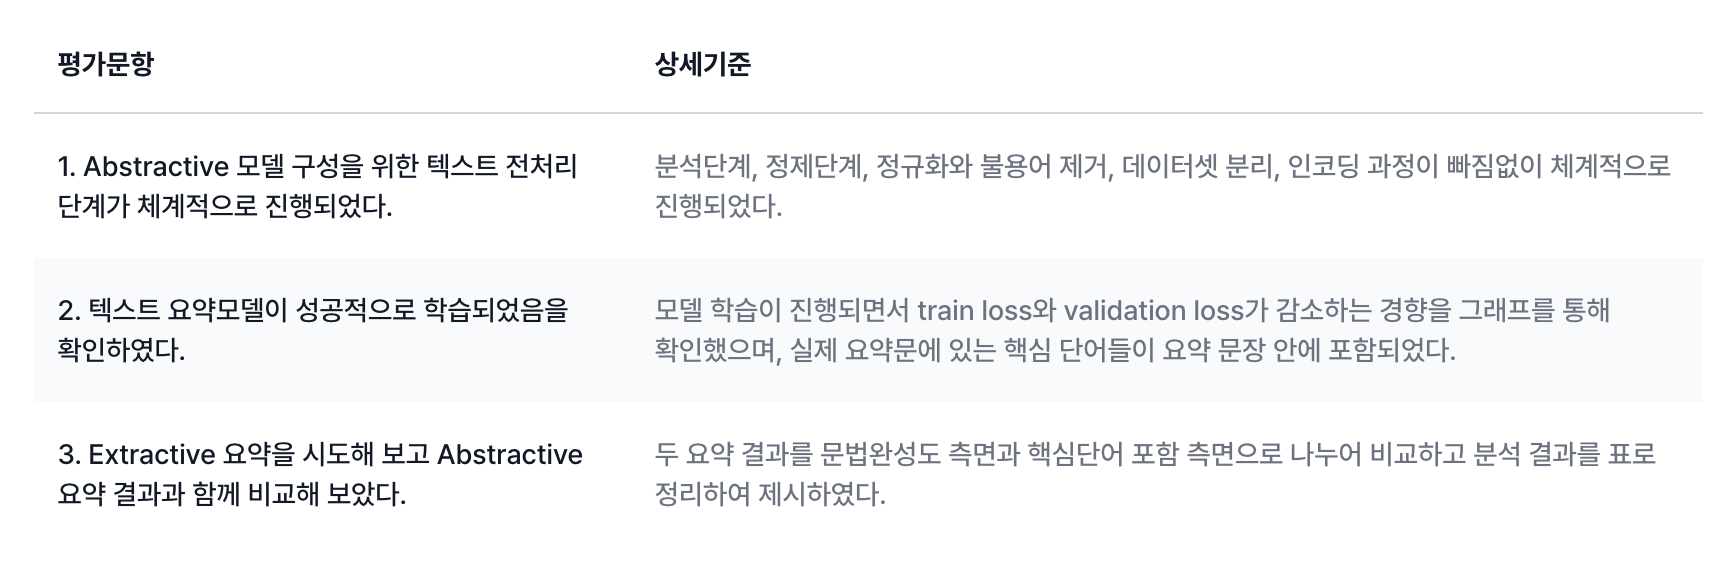

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. 데이터 수집

In [54]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [55]:
data.sample(5)

,headlines,text
40242,Faced innumerable rejections so I resorted to ...,"Revealing the reason behind her surgery, Rakhi..."
11292,Apple to stop reporting how many devices it sells,"Apple will stop reporting how many iPhones, Ma..."
1445,"Let Pandya, Rahul play while inquiry is on: BC...",BCCI acting president CK Khanna has urged CoA ...
97914,LG smartphone catches fire in man's pants,A man's LG smartphone reportedly caught fire i...
20613,10 players score in Indian women's hockey team...,"As many as 10 different players scored, includ..."


2. 데이터 전처리

- 데이터 정제
    - 중복 및 Null값 제거 (41개 제거)
    - 정규화 및 불용어 적용    
- 훈련, 테스트셋 분리
- 정수 인코딩 및 패딩

- 데이터 정제

In [56]:
# 중복 제거 및 Null 값 제거
data.drop_duplicates(subset = ['text'], inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 텍스트 정규화 작업

In [57]:
# 텍스트 정규화 사전 만들기
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


contractions.update({
    "gonna": "going to",  # 자주 사용되는 구어체
    "gotta": "got to",
    "wanna": "want to",
    "kinda": "kind of",
    "sorta": "sort of",
    "coulda": "could have",
    "shoulda": "should have",
    "woulda": "would have",
    "dunno": "do not know",
    "let's": "let us",  # 이미 포함되어 있지만 여기 추가
    "y'know": "you know",
    "ain’t": "is not",  # 소문자, 대문자 변형
    "cannot": "can not",  # 'cannot'은 기본적으로 분리된 형태도 추가
    "i'ma": "I am going to",  # 비격식적인 축약
    "outta": "out of",
    "c'mon": "come on",
    "how're": "how are",  # 누락된 'how' 관련 축약
    "what'd": "what did",  # 누락된 'what' 관련 축약
    "that'll": "that will",
    "there're": "there are",
    "here're": "here are",
    "it’s": "it is",  # 특수 문자 혼동을 방지하기 위해 추가
    "ain’t": "is not",  # 대소문자 버전 추가
    "he’s": "he is",  # 대소문자 변형 추가
    "you’ve": "you have",
    "we’re": "we are"
})

# 뉴스에서 자주 사용되는 약어 
contractions.update({
    "U.S.": "United States",
    "U.N.": "United Nations",
    "EU": "European Union",
    "NASA": "National Aeronautics and Space Administration",
    "WHO": "World Health Organization",
    "CEO": "Chief Executive Officer",
    "GDP": "Gross Domestic Product",
    "COVID-19": "Coronavirus Disease 2019",
    "UK": "United Kingdom",
    "FBI": "Federal Bureau of Investigation",
    "AI": "Artificial Intelligence",
    "OPEC": "Organization of the Petroleum Exporting Countries",
    "IMF": "International Monetary Fund",
    "R&D": "Research and Development",
    "USD": "United States Dollar"
})


# 단위 변환
contractions.update({
    "km": "kilometers",
    "kg": "kilograms",
    "$": "dollars",
    "%": "percent"
})

# 시간 날짜 표현 정규화 
contractions.update({
    "Jan.": "January",
    "Feb.": "February",
    "Mar.": "March",
    "Apr.": "April",
    "Jun.": "June",
    "Jul.": "July",
    "Aug.": "August",
    "Sep.": "September",
    "Oct.": "October",
    "Nov.": "November",
    "Dec.": "December"
})

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  174


In [58]:
# 불용어 사전
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [61]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어, 숫자 외 특수문자 등 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [62]:
# 테스트 
temp_text = 'Everything I bought was great 50, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [63]:
df = data.copy(deep=True)

data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [64]:
# text 데이터 전처리
clean_text = data['text'].apply(lambda x: preprocess_sentence(x)).tolist()

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_summary = data['headlines'].apply(lambda x: preprocess_sentence(x, False)).tolist()

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with 90 salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india 12 match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
df_cleaned = data.copy(deep=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 훈련, 테스트 데이터 분리

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 36.4627490849939
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.588216754778365


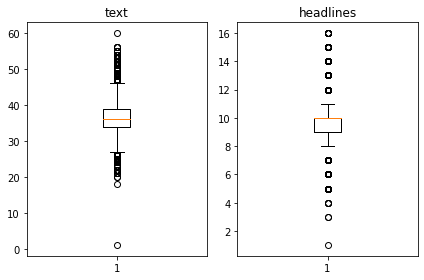

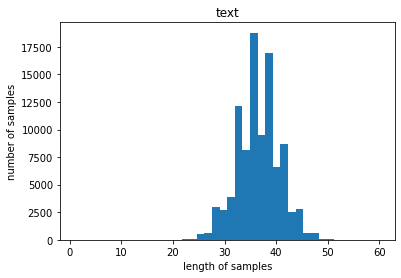

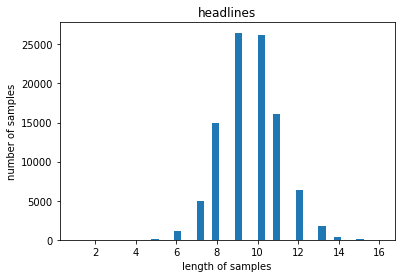

In [14]:
# 길이 분포 출력


text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
# 최대 길이 설정

text_max_len = 50
summary_max_len = 14

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.999115494103294
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9994306628710858


In [21]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98273


In [22]:
data['text'] = data['text'].apply(lambda x: x if len(x.split()) <= text_max_len else None)
data['headlines'] = data['headlines'].apply(lambda x: x if len(x.split()) <= summary_max_len else None)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98218


In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india 12 matc...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india 12 matc...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[36997 52725 36941 ... 63084 69693 76987]


In [27]:
# 정수 시퀀스를 통해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 테스트 데이터 비율 
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19643


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78575
훈련 레이블의 개수 : 78575
테스트 데이터의 개수 : 19643
테스트 레이블의 개수 : 19643


- 정수 인코딩 및 패딩

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [30]:
# 통계정보 
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 72234
등장 빈도가 6번 이하인 희귀 단어의 수: 49192
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23042
단어 집합에서 희귀 단어의 비율: 68.10089431569621
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4994699254263995


In [31]:
# 위에서 희귀 단어를 제외했을 경우 남은 단어 집합 사이즈를 고려해 재생성
src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 23000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1989, 141, 188, 158, 107, 1, 520, 2255, 215, 1229, 158, 107, 509, 440, 482, 1247, 143, 764, 11, 2255, 158, 107, 686, 18, 3395, 5], [47, 62, 48, 3, 19053, 2364, 1158, 1542, 7, 42, 105, 7349, 3, 785, 669, 2005, 269, 11916, 47, 2357, 4404, 47, 7, 48, 3, 1158, 754, 17315, 813, 2438, 462, 491, 5882, 589], [1353, 389, 117, 3, 2847, 351, 1037, 867, 348, 6362, 164, 3099, 588, 3164, 1190, 1353, 4121, 69, 164, 147, 250, 784, 1190, 162, 65, 1191, 6362, 66, 1159, 3302, 194, 494]]


In [33]:
# summary에도 동일한 작업 진행

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31987
등장 빈도가 5번 이하인 희귀 단어의 수: 21224
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10763
단어 집합에서 희귀 단어의 비율: 66.35195548191453
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.8691710156080905


In [34]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 606, 10, 106, 7, 644, 309, 147, 103, 14, 48, 1010], [1, 56, 854, 9, 6, 48, 15, 295, 455, 4857], [1, 143, 1532, 135, 1954, 117, 5, 302, 3, 3821, 2512, 822], [1, 30, 67, 502, 6, 194, 4, 9867, 176, 1182], [1, 7061, 616, 3, 1697, 4, 300, 17, 65, 318, 1011]]
target
decoder  [[606, 10, 106, 7, 644, 309, 147, 103, 14, 48, 1010, 2], [56, 854, 9, 6, 48, 15, 295, 455, 4857, 2], [143, 1532, 135, 1954, 117, 5, 302, 3, 3821, 2512, 822, 2], [30, 67, 502, 6, 194, 4, 9867, 176, 1182, 2], [7061, 616, 3, 1697, 4, 300, 17, 65, 318, 1011, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78575
훈련 레이블의 개수 : 78575
테스트 데이터의 개수 : 19643
테스트 레이블의 개수 : 19643


In [36]:
# 패딩하기

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

3. 모델설계 

- 인코더
- 디코더
- 어텐션 매커니즘 추가

In [37]:
#모델 설계 

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 어텐션 매커니즘

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

4. 모델 훈련하기

- 모델 훈련
- 결과 그래프 확인

In [40]:
# 손실함수, 옵티마이저 등 설정
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 42s 115ms/step - loss: 5.0898 - val_loss: 4.6717
Epoch 2/50
307/307 [==============================] - 35s 114ms/step - loss: 4.5254 - val_loss: 4.3013
Epoch 3/50
307/307 [==============================] - 37s 120ms/step - loss: 4.2177 - val_loss: 4.0940
Epoch 4/50
307/307 [==============================] - 38s 123ms/step - loss: 3.9997 - val_loss: 3.9328
Epoch 5/50
307/307 [==============================] - 37s 121ms/step - loss: 3.8161 - val_loss: 3.8105
Epoch 6/50
307/307 [==============================] - 38s 123ms/step - loss: 3.6592 - val_loss: 3.6969
Epoch 7/50
307/307 [==============================] - 37s 121ms/step - loss: 3.5260 - val_loss: 3.6174
Epoch 8/50
307/307 [==============================] - 37s 122ms/step - loss: 3.4087 - val_loss: 3.5649
Epoch 9/50
307/307 [==============================] - 37s 121ms/step - loss: 3.3068 - val_loss: 3.5084
Epoch 10/50
307/307 [==============================] - 37s 122ms/step - l

- 결과 그래프 확인

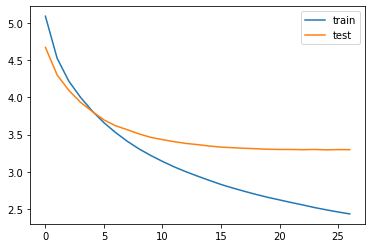

In [41]:
#손실그래프 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

5. 인퍼런스 모델 구현

In [42]:
# 인덱스 사전 생성
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

6. 모델 테스트 하기

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        # 0은 패딩 토큰, 그리고 시작 토큰 <sos>와 끝 토큰 <eos>는 제외
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

7. 추출적 요약 모델

In [83]:
import requests
from summa.summarizer import summarize

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 예측 요약 :", summarize(seq2text(encoder_input_test[i]), words=50))
    print("\n")

원문 : us media firm paid 30 000 former trump world tower remain silent claims us president donald trump fathered child former employees american media inc claimed money paid favour trump run 2016 presidential elections 
실제 요약 : firm paid man 20l to hide trump love child claim report 
예측 요약 :  us prez trump charged with fraud over nipah virus
추출적 예측 요약 : 


원문 : north korean leader kim jong un sent heartfelt congratulations russian president vladimir putin presidential election victory adding hopes long history friendly relations north korea russia continue jong un said putin victory expression russians trust russia accused helping north korea evade global sanctions nnnn 
실제 요약 : jong un sends wishes to putin on election win 
예측 요약 :  putin may be world xi if us beat us prez trump
추출적 예측 요약 : 


원문 : south korean president moon jae ordered probe defence ministry failed inform installation four additional launchers us thaad anti missile system country thaad initially deployed country marc

In [81]:
type(seq2text(encoder_input_test[i]))
# summarize(seq2text(encoder_input_test[i]), words=14)

str

- 문제점: 
추출 모델에 인풋으로 str으로 넣었는데 추출모델에 아무것도 안나옴.
왜??
함수를 잘못 사용한걸까..?

- (미완성) 문법 완성도 및 포함 단어 관련 비교를 위한 함수 생성

In [65]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np

# Perplexity 계산 함수
def calculate_perplexity(text):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    inputs = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        perplexity = torch.exp(loss)
    return perplexity.item()

# 문법 완성도 비교 함수
def compare_grammar(actual_summary, extractive_summary, abstractive_summary):
    actual_ppl = calculate_perplexity(actual_summary)
    extractive_ppl = calculate_perplexity(extractive_summary)
    abstractive_ppl = calculate_perplexity(abstractive_summary)
    
    return {
        "Actual Perplexity": actual_ppl,
        "Extractive Perplexity": extractive_ppl,
        "Abstractive Perplexity": abstractive_ppl
    }

# 실제로 함수 호출 예시
actual_summary = "This is an example of the actual summary."
extractive_summary = "This is an extractive model summary."
abstractive_summary = "Here is a summary from the abstractive model."

grammar_scores = compare_grammar(actual_summary, extractive_summary, abstractive_summary)
print(grammar_scores)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

{'Actual Perplexity': 55.30214309692383, 'Extractive Perplexity': 193.96038818359375, 'Abstractive Perplexity': 84.27754211425781}


In [67]:
from nltk.translate.bleu_score import sentence_bleu

# BLEU 점수 계산 함수
def calculate_bleu(actual_summary, generated_summary):
    reference = [actual_summary.split()]
    candidate = generated_summary.split()
    score = sentence_bleu(reference, candidate)
    return score

# 핵심 단어 포함 여부 비교 함수
def compare_keywords_bleu(actual_summary, extractive_summary, abstractive_summary):
    extractive_bleu = calculate_bleu(actual_summary, extractive_summary)
    abstractive_bleu = calculate_bleu(actual_summary, abstractive_summary)
    
    return {
        "Extractive BLEU": extractive_bleu,
        "Abstractive BLEU": abstractive_bleu
    }

# 실제로 함수 호출 예시
bleu_scores = compare_keywords_bleu(actual_summary, extractive_summary, abstractive_summary)
print(bleu_scores)

{'Extractive BLEU': 4.446808895758207e-78, 'Abstractive BLEU': 1.2882297539194154e-231}


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg